In [2]:
#Modules
from matplotlib import pyplot as plt
import numpy as np
import math
from celluloid import Camera

In [3]:
#Custom Functions

#Trapezoid Integration Function
def integrate(u,dx,x_vals):
    area_under_curve = 0
    for i in range(0,len(x_vals)-1):
        area = dx * (u[i+1]+u[i]) / 2
        area_under_curve = area_under_curve + area
    return area_under_curve

#Gaussian Function
def gaussian(x, mu, sigma):
    denom = sigma * ((2 * math.pi)**0.5)
    numerator = math.exp(((x - mu)**2) / ((sigma) **2) / -2)
    res = numerator / denom
    return res

# Habitat Preference
def preference(x):
    pi = math.pi
    res = 0.1 + math.sin(2 * pi * x / 50) ** 2  # Example 1
    #res = math.exp(-0.01*abs(x-50)**2) # Example 2
    res = np.float64(res)
    return res

# 1st Derivative of Habitat Preference Function
def preference_slope(x):
    pi = math.pi
    res = (2 * pi / 25) * math.cos(pi * x / 25) * math.sin(pi * x / 25)  # Example 1
    #res = -0.02*math.exp(-0.01*(x-50)**2)*(x-50) # Example 2
    res = np.float64(res)
    return res

# 2nd Derivative of Habitat Preference Function
def preference_slope_slope(x):
    pi = math.pi
    res = (2*pi*pi/625) * math.cos(2*pi*x/25)# Example 1
    #res = -0.02 * ((-0.02 * math.exp(-0.01*(x-50)**2)*(x-50))*(x-50)+1*math.exp(-0.01*(x-50)**2)) # Example 2
    res = np.float64(res)
    return res

#Normalized RMSE

def rmse(model, true, nx, t):
    summation = 0
    for i in range(0,nx):
        dif = (model[t][1][i] - true[0][1][i])**2
        summation = summation + dif
    rmse = (summation/nx)**0.5
    return abs(rmse)

#Convergence Flag

def converge(current_t, t_minus1000, t_minus2000):
    #function to determine whether finite difference scheme has convered
    #inputs are rows of an array
    current_t = np.float128(current_t ** 0.01)
    t_minus50 = np.float128(t_minus1000 ** 0.01)
    t_minus100 = np.float128(t_minus2000 ** 0.01)
    h1 = abs(t_minus1000 - t_minus2000)
    print(h1)
    h2 = abs(current_t - t_minus1000)
    print(h2)
    dif = abs(h1-h2)
    print(dif)
    cuttoff = np.format_float_scientific(np.float128(1e-128), unique=False, precision=128)
    mask = dif>np.float128(cuttoff)
    print(mask)
    if True not in mask:
        print("yes")
        return True
        
    

In [4]:
1/(2*dx)

10.0

In [5]:
#Model Settings

# Bounds
start = 0 # start bound
stop = 50 # stop bound


# Model parameters
dt = 0.01 # delta t
dx = 0.05  # delta x
T = 0.1 # Total time
Nt = int(T / dt)  # Number of time steps
Nx = int((abs(stop-start))/dx)  # Number of x steps
mean_sl = 0.04 #mean step length
k = (mean_sl**2)/2/dt # diffusion coefficient equal to mean step length squared
r = k * dt / dx / dx  # Fourier number

# Fourier Number Flag
if r > 0.5:
    print("Fourier Number " + str(r) +  " > 0.5. Adjust mean step length, dx, or dt")

In [6]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(start, stop + dx, dx)

# Initializing array with Nt row, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((Nt, 2, len(Xs)))

#Habitat Preference Function
w = np.zeros((1,2,len(Xs)))
w[0][0] = Xs
for i in range(0,len(Xs)):
    w[0][1][i] = preference(w[0][0][i])

#First Spatial Derivative of Habitat Preference Function
wx = np.zeros((1,2,len(Xs)))
wx[0][0] = Xs
for i in range(0,len(Xs)):
    wx[0][1][i] = preference_slope(w[0][0][i])

#Second Spatial Derivative of Habitat Preference Function
wxx = np.zeros((1,2,len(Xs)))
wxx[0][0] = Xs
for i in range(0,len(Xs)):
    wxx[0][1][i] = preference_slope_slope(w[0][0][i])
    
# Populating x values in array u
for j in range(0, Nt):
    u[j][0]=Xs

In [7]:
#Approximating the steady state space use

w0 = integrate(u = (w[0][1]**2),
               dx = dx,
               x_vals = Xs)
steady_state_u = np.zeros((1,2,len(Xs)))
steady_state_u[0][0] = Xs
steady_state_u[0][1] = (w[0][1]**2)/w0

In [8]:
# Setting Initial Condition
IC=[]
for i in range(0, len(Xs)):
    x = Xs[i]
    res = gaussian(x = x,
                   mu = 28,
                   sigma = 0.5) # Gaussin IC
    res = np.float128(res)
    IC.append(res)
u[0][1] = IC # Populating initial condition in array u

In [17]:
#Finite Difference Scheme

for j in range(0,Nt-1):
    for i in range(0,Nx-1):
        
        #Defining velocity at u[i], u[i-1], u[i-2],u[i+1],and u[i+2]
        
        c_x = np.float64((mean_sl**2) * wx[0][1][i] / w[0][1][i] / dt )
        cx_x = np.float64((mean_sl**2)/dt * (wxx[0][1][i]*w[0][1][i]-wx[0][1][i]**2) / (w[0][1][i]**2))
  
        if i == 0:
            
            c_xminus1 = np.float64((mean_sl**2) * wx[0][1][-1] / w[0][1][-1] / dt)
            c_xminus2 = np.float64((mean_sl**2) * wx[0][1][-2] / w[0][1][-2] / dt)
            
        elif i == 1:
            
            c_xminus1 = np.float64((mean_sl ** 2) * wx[0][1][0] / w[0][1][0] / dt)
            c_xminus2 = np.float64((mean_sl ** 2) * wx[0][1][-1] / w[0][1][-1] / dt)
            
        else:
            
            c_xminus1 = np.float64((mean_sl ** 2) * wx[0][1][i-1] / w[0][1][i-1] / dt)
            c_xminus2 = np.float64((mean_sl ** 2) * wx[0][1][i-2] / w[0][1][i-2] / dt)
            
        if i == Nt:
            
            c_xplus1 = np.float64((mean_sl**2) * wx[0][1][0] / w[0][1][0] / dt)
            c_xplus2 = np.float64((mean_sl**2) * wx[0][1][1] / w[0][1][1] / dt)
            
        elif i == (Nt - 1):
            
            c_xplus1 = np.float64((mean_sl ** 2) * wx[0][1][-1] / w[0][1][-1] / dt)
            c_xplus2 = np.float64((mean_sl ** 2) * wx[0][1][0] / w[0][1][0] / dt)
            
        else:
            
            c_xplus1 = np.float64((mean_sl ** 2) * wx[0][1][i+1] / w[0][1][i+1] / dt)
            c_xplus2 = np.float64((mean_sl ** 2) * wx[0][1][i+2] / w[0][1][i+2] / dt)
  
        print(c_x,c_xminus1,c_xminus2,c_xplus1,c_xplus2)
        print(u[j][1][i])
        #Calcutlting u(x) at future timesteps
    
        if i == 0:
            diffusion = r * (np.float128(u[j][1][i + 1]) - 2 * np.float128(u[j][1][i]) + np.float128(u[j][1][-1]))
            advection = -dt*(cx_x*np.float128(u[j][1][i]) + (1/(2*dx))*(c_xplus1 * np.float128(u[j][1][i + 1]) - c_xminus1 * np.float64(u[j][1][-1])))
            print(advection)
            print(diffusion)
            u[j + 1][1][i] = u[j][1][i] + diffusion + advection 

        elif i == Nx:

            diffusion = r * (np.float64(u[j][1][0]) - 2 * np.float64(u[j][1][i]) + np.float64(u[j][1][i - 1]))
            advection = -dt*(cx_x*np.float64(u[j][1][i]) + (1/(2*dx))*(c_xplus1 * np.float64(u[j][1][0]) - c_xminus1 * np.float64(u[j][1][i-1])))
            print(advection)
            print(diffusion)
            u[j + 1][1][i] = u[j][1][i] + diffusion + advection 

        else:
            diffusion = r * (np.float64(u[j][1][i + 1]) - 2 * np.float64(u[j][1][i]) + np.float64(u[j][1][i - 1]))
            advection = -dt*(cx_x*np.float64(u[j][1][i]) + (1/(2*dx))*(c_xplus1 * np.float64(u[j][1][i+1]) - c_xminus1 * np.float64(u[j][1][i-1])))
            print(advection)
            print(diffusion)
            u[j + 1][1][i] = np.float64(u[j][1][i] + diffusion + advection) 


    area = integrate(u = np.float64(u[j + 1][1]),
                     dx = dx,
                     x_vals = Xs)
    print(area)
    u[j+1][1] = np.float64(u[j+1][1])/np.float64(area)

    percent_comp = ((j+2)/(Nt))*100
    if ( percent_comp % 1 == 0):
        print(str(percent_comp)," %")
    if(percent_comp % 10 == 0):
        filename = "/Users/rhemitoth/Documents/Fall 2022/Math 19a/finalproject/RT_Math19A_Final/np_checkpoints/checkpoint{var}".format(var = str(percent_comp))
        np.save(filename, u)
    if j >= 2000:
        converge_YN = converge(current_t = u[j][1],
                              t_minus1000 = u[j-1000][1],
                              t_minus2000 = u[j-2000][1])
        if converge_YN == True:
            print("Model Converged")
            break



0.0 -9.849193951855566e-17 -0.0025255551931589715 0.0025255551931590296 0.00504473957254331
0.0
-0.0
0.0
0.0025255551931590296 0.0 -9.849193951855566e-17 0.00504473957254331 0.007551234071228105
0.0
-0.0
0.0
0.00504473957254331 0.0025255551931590296 0.0 0.007551234071228105 0.010038822235663698
0.0
-0.0
0.0
0.007551234071228105 0.00504473957254331 0.0025255551931590296 0.010038822235663698 0.012501439357130587
0.0
-0.0
0.0
0.010038822235663698 0.007551234071228105 0.00504473957254331 0.012501439357130587 0.01493321906340995
0.0
-0.0
0.0
0.012501439357130587 0.010038822235663698 0.007551234071228105 0.01493321906340995 0.017328536638243294
0.0
-0.0
0.0
0.01493321906340995 0.012501439357130587 0.010038822235663698 0.017328536638243294 0.019682048427587435
0.0
-0.0
0.0
0.017328536638243294 0.01493321906340995 0.012501439357130587 0.019682048427587435 0.021988726798394316
0.0
-0.0
0.0
0.019682048427587435 0.017328536638243294 0.01493321906340995 0.021988726798394316 0.024243890233298537
0.

-0.019011159678429847 -0.018738636633512166 -0.018467289110478197 -0.01928487736258365 -0.019559808916607503
2.489214433435836e-153
-6.4209131846520435e-155
9.510518977152151e-153
-0.01928487736258365 -0.019011159678429847 -0.018738636633512166 -0.019559808916607503 -0.019835973682031802
1.777112057808089e-154
-4.697965238411879e-156
6.868331297628038e-154
-0.019559808916607503 -0.01928487736258365 -0.019011159678429847 -0.019835973682031802 -0.02011339110857422
1.2561508634543988e-155
-3.402778292533972e-157
4.9109535428927335e-155
-0.019835973682031802 -0.019559808916607503 -0.01928487736258365 -0.02011339110857422 -0.020392080751086096
8.791097036769894e-157
-2.4398886401898735e-158
3.4765450917158437e-156
-0.02011339110857422 -0.019835973682031802 -0.019559808916607503 -0.020392080751086096 -0.020672062266131785
6.091418442200038e-158
-1.7318904949318086e-159
2.4366729271772598e-157
-0.020392080751086096 -0.02011339110857422 -0.019835973682031802 -0.020672062266131785 -0.0209533554

In [13]:
#Normalized Root Mean Squared Error
error = rmse(model = u,
           true = steady_state_u,
           nx = Nx,
           t = Nt-1)

print("Root Mean Squared Error = " + str(error))

Root Mean Squared Error = 0.10769816452428897


In [14]:
#Checking for conservation

res = integrate(u = u[Nt-1][1],
              dx = dx,
              x_vals = Xs)
print(res)

0.9999999999999999


In [1]:
# Animation
fig1, ax1 = plt.subplots()
camera = Camera(fig1)
for i in range(Nt):
    Ys= u[i][1]
    if i%500 == 0:
        if i == 0:
            ax1.plot(w[0][0], w[0][1], color = "#5a5a5a", label = "w(x)", linestyle = "dashed")
            x = ax1.plot(Xs, Ys, color="#959e19", label="u(x,t)")
            y = ax1.plot(Xs,steady_state_u[0][1], color = 'black', linestyle = 'dotted', label = "steady state u(x,t)")
        else:
            ax1.plot(w[0][0], w[0][1], color="#5a5a5a", linestyle="dashed")
            x = ax1.plot(Xs, Ys, color="#959e19")
            y = ax1.plot(Xs, steady_state_u[0][1], color='black', linestyle='dotted')
        ax1.legend(loc="upper right")

        camera.snap()
animation = camera.animate()
animation.save('AdvectionDiffusion_CDA.mp4', writer = 'ffmpeg')

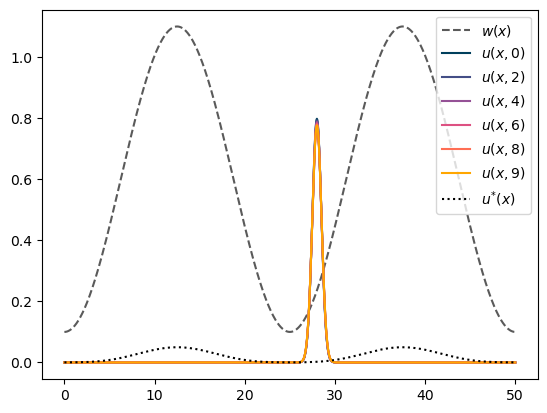

In [16]:
# Plot
fig2 = plt.figure()
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]
plt.plot(Xs,w[0][1], color = "#5a5a5a", label = r"$w(x)$", linestyle = "dashed")
plt.plot(Xs,t0, label = r'$u(x,0)$', color = "#003f5c" )
plt.plot(Xs,t1, label = fr'$u(x,{int(0.2*Nt)})$', color = "#444e86")
plt.plot(Xs,t2, label = fr'$u(x,{int(0.4*Nt)})$', color = "#955196")
plt.plot(Xs,t3, label = fr'$u(x,{int(0.6*Nt)})$', color = "#dd5182")
plt.plot(Xs,t4, label = fr'$u(x,{int(0.8*Nt)})$', color = "#ff6e54")
plt.plot(Xs,t5, label =fr'$u(x,{int(Nt-1)})$', color = "#ffa600")
plt.plot(Xs,steady_state_u[0][1], color = 'black', linestyle = 'dotted', label = r"$u^{*}(x)$")
plt.legend(loc="upper right")
plt.savefig("AdvectionDiffusion.png", dpi = 350)
plt.show()

